<div class="alert-warning">
 <font size="+2"> <b> Variant calling and VCF processing </b> </font>
</div>

This tutorial will cover the steps for performing Variant calling and working on the resulting VCF file format. We will be using the Hifi and RNA-seq mapping data obtained from Galaxy. At the end of this tutorial you will be able to:
- call variants using alignment files
- extract data from VCF files using Python
- filter and count variants 

The present tutorial, like the rest of the course material, is available at our [open-source github repository](https://github.com/hds-sandbox/NGS_summer_course_Aarhus). 



A few introductory points to run this notebook:

* To use this notebook, use the `NGS (python)` kernel that contains the packages. Choose it by selecting `Kernel -> Change Kernel` in the menu on top of the window.

<figure>
<img src="images/kernelchoice.png" width="700" alt="Kernel Choice" class="center">
</figure>

* In this notebook you will use both bash and python commands, the bash commands are marked with an "!" sign at the beginning of the line
*  You can run the code in each cell by clicking on the run cell sign, or by pressing <kbd> Shift </kbd> +<kbd> Enter </kbd>.  When the code is done running, a small green check sign will appear on the left side
*   You need to run the cells in sequential order, please do not run a cell until the one above finished running and do not skip any cells
*   Each cell contains a short description of the code and the output you should get. Please try not to focus on understanding the code for each command in too much detail, but rather try to focus on the output 
*   You can create new code cells by pressing <kbd> + </kbd> in the Menu bar above. 


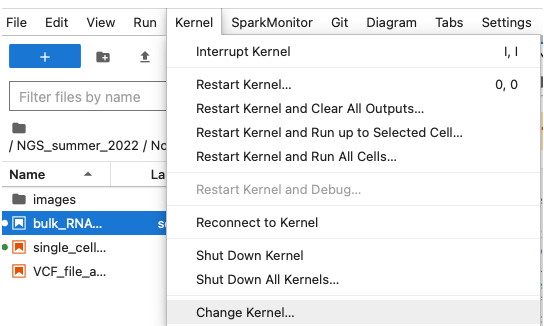

Import the necessary Python libraries:

In [1]:
import pandas
import allel
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Check if the data folder is there

In [2]:
%%bash
sh .Scripts/dataDownloadScript.sh

Datasets folder already exists, no need to download it


Create a folder for the data necessary to VCF data analysis

In [3]:
%%bash
mkdir -p Data_for_VCF_analysis

# Use the `bam` files generated from the alignment of raw reads

We will use the data created during the alignment session of the course. You had two possibilities:


- using the interactive `Galaxy` platform as explained in !!!!!!!!!!!!!!!. In this case you will need to upload the some of the created data into the folder `Data_for_VCF_analysis`, renaming the files as follows:

    *  Hifi reads mapped to Contig1: `HIFI_contig_1.bam`
    *  Hifi reads mapped to Contig2: `HIFI_contig_2.bam`
    *  Hifi reads mapped to Contig 1 and 2: `HIFI_contig_1_2_asm5.bam` (you can of course choose the one with the `map-pb` alignment option from the alignment notebook)
    *  S10 RNAseq reads mapped to  Contig 1 and 2 (After merging the bam files): `RNA_S10_merged.bam`
    *  Ti RNAseq reads mapped to  Contig 1 and 2 (After merging the bam files): `RNA_TI_merged.bam`

- using the notebook `01_align.ipynb`. In that case, you just need to run the command below, linking the data in the `results` folder into the folder `Data_for_VCF_analysis`.

In [5]:
%%bash
ln -s `realpath results/HIFI_alignment/PacBio_clover_alignment_1.bam` Data_for_VCF_analysis/HIFI_contig_1.bam
ln -s `realpath results/HIFI_alignment/PacBio_clover_alignment_2.bam` Data_for_VCF_analysis/HIFI_contig_2.bam
ln -s `realpath results/HIFI_alignment/PacBio_clover_alignment_1_2_asm5.bam` Data_for_VCF_analysis/HIFI_contig_1_2.bam
ln -s `realpath results/STAR_output/S10_align_contigs_1_2_merge/S10.sorted.bam` Data_for_VCF_analysis/RNA_S10_merged.bam
ln -s `realpath results/STAR_output/TI_align_contigs_1_2_merge/TI.sorted.bam` Data_for_VCF_analysis/RNA_TI_merged.bam

# Variant calling

We will use a tool named `bcftools` to find variants in the alignment files (.bam) relative to the reference genome, in this case, the file DNA_Contig1_2.fasta. In this way we can identify positions in the genome where the sequence of the aligned reads differ from the reference genome they were mapped to. There are multiple types of genetic variation, for example, SNPs (single nucleotide polymorphism), indels (insertions or deletions) and structural variations, for example chromosomal rearrangements. 
Here we will only be working with SNPs, thus we will use the terms variants and SNPs interchangeably. The called variants will be stored in a specific format file, named Variant Call Format (VCF).
<br>
When looking at an alignment file in IGV you should easily recognize the SNP positions. You can see that at the marked positions all the mapped reads have a mismatch compared to the reference. 

<figure>
<img src="images/alignment.png" width="400" alt="Alignment on IGV" class="center">
</figure>
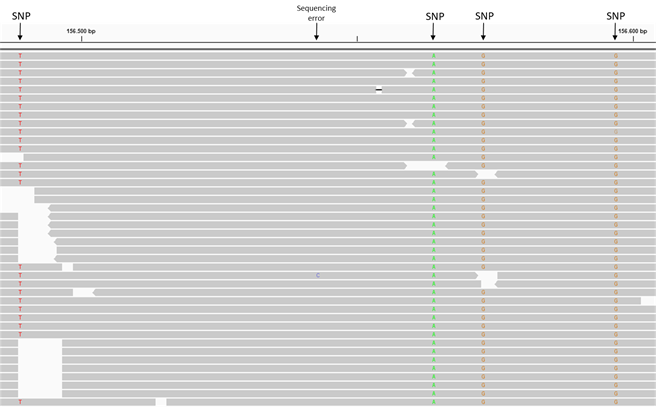

You will be calling **two types of SNPs** in this notebook.
First, we will find subgenome SNPs using the Hifi reads mapped to white clover Contig1 and Contig2. These are positions in the contigs that are different between the two subgenomes of white clover.

Secondly, we will find SNPs that differentiate between the sequenced white clover S10 (the reference genome) and Ti genotype, using RNA-seq read mapping. 

Create a folder that will store all the files generated in this notebook.

In [ ]:
!mkdir -p results/VCF_Files

## Call subgenome SNPs using the Hifi alignments and the reference genome
As previously mention we will use the `bcftools` software to call SNPs from alignment files. `bcftools` is a toolkit for variant calling and manipulating VCF files. If you are interested you can find all the functionalities here http://samtools.github.io/bcftools/bcftools.html#call. 

We mainly need two commands for this step, first the `bcftools mpileup`  which takes as input the alignment and the genome reference files followed by `bcftools call` to produce VCF files.

The cell below  will generate 3 VCF files stored in the folder VCF_Files using the Hifi alignment files uploaded from Galaxy.

In [ ]:
!bcftools mpileup --threads 4 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta Data_for_VCF_analysis/HIFI_contig_1.bam | bcftools call -mv -Ov -o results/VCF_Files/HIFI_Contig_1.vcf
!bcftools mpileup --threads 4 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta Data_for_VCF_analysis/HIFI_contig_2.bam | bcftools call -mv -Ov -o results/VCF_Files/HIFI_Contig_2.vcf
!bcftools mpileup --threads 4 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta Data_for_VCF_analysis/HIFI_contig_1_2.bam | bcftools call -mv -Ov -o results/VCF_Files/HIFI_Contig_1_2.vcf

<div class="alert-success"> <font size="+2"> <b> TASK </b> </font> </div>


* Inspect the VCF files using IGV, comparing them to the specific alignment BAM files. (You can download the VCF files to your computer from the VCF_Files folder)
* Are there any problematic positions that may not represent true SNPs?
* How can you use the
HiFi reads aligned to Contigs1+2 identify potential problems? Hint: Try scrolling to the ends of the
contigs.

## Call SNPs using the two RNA-seq genotypes, S10 and Ti

We will repeat the same step as above this time using the RNA-seq alignment files for the two white clover genotypes (S10 and Ti). These commands will produce another two VCF files, stored in the same folder.

In [ ]:
!bcftools mpileup --threads 4 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta Data_for_VCF_analysis/RNA_S10_merged.bam | bcftools call -mv -Ov -o results/VCF_Files/RNA_S10_merged.vcf
!bcftools mpileup --threads 4 -Ou --skip-indels -f ../Data/Clover_Data/DNA_Contig1_2.fasta Data_for_VCF_analysis/RNA_TI_merged.bam | bcftools call -mv -Ov -o results/VCF_Files/RNA_TI_merged.vcf

<div class="alert-success"> <font size="+2"> <b> TASK </b> </font> </div>

* Inspect one of the VCFs and the corresponding alignment files in IGV.
* Is it relevant to filter for false positives in this case, and what parameters would you look
further into?

# VCF files processing and filtering

Take a look at what one of the previously generated VCF files contains by running the cell below.

A VCF file begins with the meta-information lines starting with '##' followed by one header line, starting with '#'. Next, there are the data lines, each describing a genetic variant for a certain position in the genome. Each data line contains multiple tab-delimited columns with information about the variant. There are 9 fixed columns, labelled “CHROM”, “POS”, “ID”, “REF”, “ALT”, “QUAL”, “FILTER”, “INFO” and “FORMAT”. Find more about the content of those columns [in this wikipedia page](https://en.wikipedia.org/wiki/Variant_Call_Format).

In the sample column you can find the most likely genotype of the sample. For diploid organisms, there will be a 0 value for reference allele and 1 for the alternate allele. 

<figure>
<img src="images/vcf_genotype.png" width="700" alt="Possible genotypes in the data" class="center">
<figcaption> Figure: possible genotypes in the data. </figcaption>
</figure>
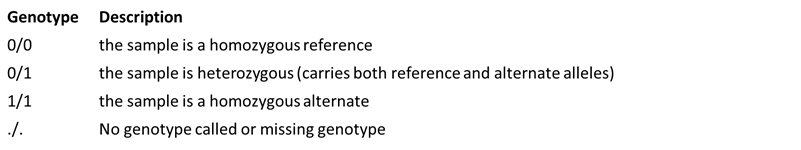

For example, here we read the first 50 rows from the RNAseq_S10_merged.vcf. You can see that the file format follows the same pattern as explained above.

In [ ]:
!cat results/VCF_Files/RNA_S10_merged.vcf | head -50

Next, in order to generate plots of the metrics stored in the VCF files, we will first import the VCF files in Python using the `scikit-allel` package. This package contains a series of function helpful for processing variant calling files.
<br>
For now, we will import only the VCF files generated using the Hifi data alignments. You can ignore the warning.


In [ ]:
#Import the VCF files
Hifi_Contig_1_vcf = allel.read_vcf('results/VCF_Files/HIFI_Contig_1.vcf', fields='*')
Hifi_Contig_2_vcf = allel.read_vcf('results/VCF_Files/HIFI_Contig_2.vcf', fields='*')
Hifi_Contig_1_2_vcf = allel.read_vcf('results/VCF_Files/HIFI_Contig_1_2.vcf', fields='*')

Let's check the number of SNPs in each of the three VCF files.

The first two VCF files contain subgenome SNPs. You can see that we identified a have a high number of polymorphisms between the two subgenomes. On the other hand the Hifi_Contig1_2_vcf file contains what we would call false positives, as we called SNPs using the same Hifi reads that were used for assembling the reference genome. As expected the number of SNPs in this file is much smaller.

In [ ]:
print("Number of SNPs in Hifi Contig 1 vcf file:", Hifi_Contig_1_vcf['variants/POS'].size)
print("Number of SNPs in Hifi Contig 2 vcf file:", Hifi_Contig_2_vcf['variants/POS'].size)
print("Number of SNPs in Hifi Contig 1 and 2 vcf file:", Hifi_Contig_1_2_vcf['variants/POS'].size)

As an overview of the distribution of SNPs, we can plot the density of SNPs across the contigs. We have defined a function called `plot_variant_density` in the file `../Scripts/pythonScripts.sh` that does exactly that. We use that to plot the SNP density across the contigs in the three VCF files in bins of 5000 bp.

We can approximate that a SNP density of 0.1 SNPs/bp repesents one polymorphic site at every ten nucleotides. You can see that for the two contigs there are regions more conserved between the two subgenomes, which show a low density of SNPs and more variable regions, which have a higher SNP density.

In the third plot we can mainly observe SNPs at the beging of the contigs, as you have probably also oberved when inspecting the files in IGV. Taking a look at the scale of the y-axis you can oberve that the SNP density for 'Hifi_Contig1_2_vcf' is much smaller compared to the other two files.

Note: For easier plotting of the files that contain SNPs from both Contig 1 and 2, the SNP density is plotted as an overlay of both contigs.

In [ ]:
#Plot SNP density
plot_variant_density(Hifi_Contig_1_vcf, window_size=5000, title='Contig 1 Raw SNP density')
plot_variant_density(Hifi_Contig_2_vcf, window_size=5000, title='Contig 2 Raw SNP density')
plot_variant_density(Hifi_Contig_1_2_vcf, window_size=5000, title='Contig 1 and 2 Raw SNP density')

We can also plot some of the most relevant parameters from the VCF files, such as the read depth and the quality, to have an overview of the quality of the SNPs in these samples. We defined for that the function `plot_variant_hist` in the file `../Scripts/pythonScripts.sh`.

We can plot the metrics "DP" (Read depth),  "QUAL" (Quality score), and "MQ" (Mapping quality for `Hifi_Contig1_vcf`. 
The x-axis represents the chosen metric, while the y-axis represents the number of SNPs. You can observe that the majority of the SNPs from this file have a high quality.

In [ ]:
plot_variant_hist(Hifi_Contig_1_vcf,'DP', "mediumblue")
plot_variant_hist(Hifi_Contig_1_vcf, 'QUAL', "forestgreen")
plot_variant_hist(Hifi_Contig_1_vcf, 'MQ', "darkred")

<div class="alert-success"> <font size="+2"> <b> TASK </b> </font> </div>

* In the two cells below generate the same three plots as above using the VCF files for Contig 2 and Contig 1+2.

* You will just need to copy the three command lines from the cell above and replace the name of the VCF files.

In [ ]:
#Plot the metrics for Contig 2

In [ ]:
#Plot the metrics for Contig 1 + 2

As you can observe in the plots above, there are some positions with very low read depth and low quality. Those might represent false-positive variants. Thus, we will filter the VCF files in order to eliminate those positions.
<br>
For this purpose, we will use another `bcftools` function `bcftools filter`. We can pass thresholds for all the info metrics to this function using the "-i" flag. Below is just an example of the thresholds, you can change the values to suit your files.
<br>
Note that this command will generate a new filtered VCF file in the "VCF_Files" Folder.


In [ ]:
!bcftools filter -i '(QUAL>150) & (DP > 20) & (MQ > 40)' results/VCF_Files/HIFI_Contig_1.vcf -O v > results/VCF_Files/HIFI_Contig_1_filtered.vcf

In [ ]:
!bcftools filter -i '(QUAL>150) & (DP > 20) & (MQ > 40)' results/VCF_Files/HIFI_Contig_2.vcf -O v > results/VCF_Files/HIFI_Contig_2_filtered.vcf

In [ ]:
!bcftools filter -i '(QUAL>150) & (DP > 20) & (MQ > 40)' results/VCF_Files/HIFI_Contig_1_2.vcf -O v > results/VCF_Files/HIFI_Contig_1_2_filtered.vcf

Read the filtered VCF files in python and generate the same plots as above. We can read the VCF file and gnerate all the plots in one cell this time.

Check how many positions have been eliminated by the filter and compare the plots with the ones for the unfiltered VCFs.

If you consider that there are still positions with with low quality you can change the filter and repeat the process.

In [ ]:
Hifi_Contig1_filtered = allel.read_vcf('results/VCF_Files/HIFI_Contig_1_filtered.vcf', fields='*')

print("Number of SNPs in Contig 1 VCF filtered file:", Hifi_Contig1_filtered['variants/POS'].size)

#Plot SNP density
plot_variant_density(Hifi_Contig1_filtered, window_size=5000, title='Contig 1 Filtered variant density')
#Plot metrics
plot_variant_hist(Hifi_Contig1_filtered,'DP',  "mediumblue")
plot_variant_hist(Hifi_Contig1_filtered, 'QUAL',  "forestgreen")
plot_variant_hist(Hifi_Contig1_filtered, 'MQ', "darkred")

<div class="alert-success"> <font size="+2"> <b> TASK </b> </font> </div>

* Compare the VCF files before and after filtering in IGV. 

<div class="alert-success"> <font size="+2"> <b> TASK </b> </font> </div>

* In the two cells below generate the same plots as above using the filtered VCF files for Contig 2 and Contig 1 + 2.  You will just need to copy the three command lines from the cell above and replace the name of the VCF files.

In [ ]:
#Figures for Contig 2 Filtered VCF


In [ ]:
#Figures for Contig 1 + 2 Filtered VCF



<div class="alert-success"> <font size="+2"> <b> TASK </b> </font> </div>


* Repeat the quality check and filtering as described above for the two RNA-seq VCF files:
<br>
You will need to fill the empty cells with the appropriate commands.

Read the VCF files in Python:

In [ ]:
vcf_S10_RNA = allel.read_vcf('results/VCF_Files/RNA_S10_merged.vcf', fields='*')
vcf_Ti_RNA = allel.read_vcf('results/VCF_Files/RNA_TI_merged.vcf', fields='*')

Print the number of SNPs in the two RNA-seq VCF files. Note that the number of SNPs is much smaller than for the Hifi VCF files. Also, there is a difference in the number of SNPs for the two genotypes. As S10 RNA-seq data originates from the same genotype as the referece genome, one would expect a small number of SNPs to be identified in this case. 

In [ ]:
print("Number of SNPs in S10 RNA-seq VCF file:", vcf_S10_RNA['variants/POS'].size)
print("Number of SNPs in Ti RNA-seq VCF file:", vcf_Ti_RNA['variants/POS'].size)

Generate SNP density plots using the plot_variant_density() function:

Generate info histograms using the plot_variant_hist() function for the same fields. 
You should observe that the metrics for the RNA-seq vcf files are quite different from the ones using Hifi reads.

Filter the VCF files using `bcftools` and your selected tresholds after inspecting the VCF files.
Add the filter thresholds before running the command.

In [ ]:
!bcftools view -i 'add filter thresholds here' results/VCF_Files/RNA_S10_merged.vcf -O v > results/VCF_Files/RNA_S10_merged_filtered.vcf
!bcftools view -i 'add filter thresholds here' results/VCF_Files/RNA_TI_merged.vcf -O v > results/VCF_Files/RNA_TI_merged_filtered.vcf

Read the filtered VCFs in python:

In [ ]:
vcf_S10_RNA_filtered = allel.read_vcf('results/VCF_Files/RNA_S10_merged_filtered.vcf', fields='*')
vcf_Ti_RNA_filtered = allel.read_vcf('results/VCF_Files/RNA_TI_merged_filtered.vcf', fields='*')

Check the number of SNPs in the filtered VCF files:

In [ ]:
print("Number of SNPs in the filtered S10 RNA-seq VCF file:", vcf_S10_RNA_filtered['variants/POS'].size)
print("Number of SNPs in the filtered Ti RNA-seq VCF file:", vcf_Ti_RNA_filtered['variants/POS'].size)

Plot same histograms for the filtered VCF files.

<div class="alert-success"> <font size="+2"> <b> TASK </b> </font> </div>

* Is it relevant to filter for false positives in this case, and what parameters  would you look further into?

# Genotypes counting

We want to count the different genotypes in each of the five filtered VCF files generated previously. To make this task easier we can take advantage of the counting functions in the `scikit-allel`  package. We have used those to implement a little function called `position_count` in the file `../Scripts/pythonScripts.sh`.

<div class="alert-success"> <font size="+2"> <b> TASK </b> </font> </div>

You can then use the function with each of the 5 filtered VCF files to count the number of positions. You need to fill the names of the VCF files imported in Python.

In [ ]:
#Contig 1 filtered VCF
position_count(Hifi_Contig1_filtered)

In [ ]:
#Contig 2 filtered VCF
position_count()

In [ ]:
#Contig 1 and 2 filtered VCF
position_count()

In [ ]:
#RNAseq S10 filtered VCF
position_count()

In [ ]:
#RNAseq Ti filtered VCF
position_count()

# Comparison of VCF files 

Compare the VCF files with subgenome variants and the VCF files with S10/Tienshan genotype specific variants obtained from RNA-seq mapping

We want now to find overlapping position between the Contig 1 and Contig 2 Hifi VCF files and the Ti RNAseq VCF file. 

To ease this task we will first create two merged VCF files containing:


*   Hifi Contig 1 VCF + Ti RNAseq VCF
*   Hifi Contig 2 VCF + Ti RNAseq VCF

Once again, we will use `bcftools` for this task, using the merge function. However, the `bcftools merge`  function works only with compressed and indexed VCF files, so first we will do this. 


In [ ]:
!bcftools view results/VCF_Files/HIFI_Contig_1_filtered.vcf -Oz -o results/VCF_Files/HIFI_Contig_1_filtered.vcf.gz
!bcftools index results/VCF_Files/HIFI_Contig_1_filtered.vcf.gz -f -o results/VCF_Files/HIFI_Contig_1_filtered.vcf.gz.csi

!bcftools view results/VCF_Files/HIFI_Contig_2_filtered.vcf -Oz -o results/VCF_Files/HIFI_Contig_2_filtered.vcf.gz
!bcftools index results/VCF_Files/HIFI_Contig_2_filtered.vcf.gz -f -o results/VCF_Files/HIFI_Contig_2_filtered.vcf.gz.csi

!bcftools view results/VCF_Files/RNA_TI_merged_filtered.vcf -Oz -o results/VCF_Files/RNA_TI_merged_filtered.vcf.gz
!bcftools index results/VCF_Files/RNA_TI_merged_filtered.vcf.gz -f -o results/VCF_Files/RNA_TI_merged_filtered.vcf.gz.csi

Now we can merge Contig 1 VCF with the Ti RNA VCF and keep only positions that match between the two files by filtering out any positions with missing genotypes.

In [ ]:
!bcftools merge results/VCF_Files/HIFI_Contig_1_filtered.vcf.gz results/VCF_Files/RNA_TI_merged_filtered.vcf.gz | bcftools filter -e 'GT="./."' > results/VCF_Files/TI_Contig_1_merged.vcf

Merge Contig 2 VCF with the Ti RNA VCF and keep only positions that match between the two files.

In [ ]:
!bcftools merge results/VCF_Files/HIFI_Contig_2_filtered.vcf.gz results/VCF_Files/RNA_TI_merged_filtered.vcf.gz | bcftools filter -e 'GT="./."' > results/VCF_Files/TI_Contig_2_merged.vcf

Take a look at the merged VCF file.
<br>
You can see that compared with the VCF files for just one sample, there is now a new column in the file, with the corresponding genotype for the second sample that we merged.

In [ ]:
!cat results/VCF_Files/TI_Contig_1_merged.vcf | head -50

In order to count the genotypes for the matching positions we can use once again `bcftools filter`  command. Only that this time we will filter based on the genotype columns for the two samples (GT[0] and GT[1]). GT[0] repesents the genotype for the first sample in the merge command and GT[1] is the genotype for the second sample in the merge command.  

*   AR - heterozygous
*   AA - heterozygous alternate

For example, the filter `GT[0]="AR" && GT[1]="AR"` will keep only position in which both samples have a heterozygous genotype.
A quick way to count how many positions are in the VCF file is by suing the simple bash command `grep`. This will count all the lines in the VCF files that do not start with a `#`, thus all the data lines. 

In [ ]:
!./bcftools filter  -i 'GT[0]="AR" && GT[1]="AR"' results/VCF_Files/TI_Contig_1_merged.vcf | grep -c -v "^#"
!./bcftools filter  -i 'GT[0]="AR" && GT[1]="AA"' results/VCF_Files/TI_Contig_1_merged.vcf | grep -c -v "^#"
!./bcftools filter  -i 'GT[0]="AA" && GT[1]="AR"' results/VCF_Files/TI_Contig_1_merged.vcf | grep -c -v "^#"
!./bcftools filter  -i 'GT[0]="AA" && GT[1]="AA"' results/VCF_Files/TI_Contig_1_merged.vcf | grep -c -v "^#"

<div class="alert-success"> <font size="+2"> <b> TASK </b> </font> </div>

* Use the same commands as above to count the positions marching the filters in the  Contig2_Ti_merged.vcf.

# Wrapping up  🎉 🎉 🎉

In this exercise, you identified polymorphisms between the two white clover subgenomes using Hifi reads alignment files and SNPs specific for the white clover Tienshan genotype using RNA-seq alignment files. You learned how to import VCF files in Python to extract data and created plots. You also filtered low-quality variants from the VCF files and counted genotypes. 

